# Part 2: Spatial Interaction models

## III. Models and calibration

### III.1. Briefly introduce the spatial interaction models covered in the lectures using equations and defining the terms, taking particular care in explaining the role of the parameters.  

# Spatial Interaction Models

Spatial interaction models are designed to predict the flow of people, goods, or information between locations. They relate to the attractiveness of the destination and the mass or 'emissivity' of the origin, considering also the distance or cost between them. Four main types of spatial interaction models are commonly used: Unconstrained, Production-constrained, Attraction-constrained, and Doubly constrained models.

## 1. Unconstrained Model

The Unconstrained Model is the simplest form where the flows are not limited by the capacity of either the origin or destination. The flow from origin *i* to destination *j* is defined as:

$$ T_{ij} = k \cdot O_i^\gamma \cdot D_j^\gamma \cdot d_{ij}^{-\beta} $$

The parameters $\gamma$ and $\beta$ play a role in adjusting the flow's sensitivity to the mass of the origins and destinations and the distance between them, respectively. The scaling parameter $k$ ensures that the model's predictions sum to the total observed flows.

## 2. Production-Constrained Model

In this model, the total outflow from each origin is fixed, and it is defined as:

$$ T_{ij} = A_i \cdot O_i \cdot D_j^\gamma \cdot d_{ij}^{-\beta} $$

Here, $A_i$ is a balancing factor that ensures the sum of predicted flows from each origin matches the observed outflows. It adjusts the model to respect the known constraints at the origin.

## 3. Attraction-Constrained Model

The Attraction-Constrained Model is similar to the Production-Constrained Model but applies constraints at the destinations instead:

$$ T_{ij} = D_j \cdot B_j \cdot O_i^\gamma \cdot d_{ij}^{-\beta} $$

Where $B_j$ is the balancing factor for each destination, ensuring the predicted inflows match the observed inflows.

## 4. Doubly Constrained Model

The Doubly Constrained Model incorporates both origin and destination constraints:

$$ T_{ij} = A_i \cdot O_i \cdot B_j \cdot D_j \cdot d_{ij}^{-\beta} $$

Balancing factors $A_i$ and $B_j$ are determined iteratively. This model is considered more realistic since it reflects scenarios where both origins and destinations have limitations.

In practice, these models often require calibration using observed data to estimate parameters $\gamma$ and $\beta$. The models can be estimated using regression techniques, with the Production and Attraction-Constrained Models often taking the form of Poisson regression in log-linear space. Here, the origins and destinations can be represented as categorical predictors rather than numerical values, allowing the model to capture the qualitative nature of spatial interactions.

The models' applicability can range from urban planning and transport forecasting to migration studies and are powerful tools for understanding and predicting spatial dynamics within various contexts.
ing spatial dynamics within various contexts.
ing spatial dynamics within various contexts.
tial dynamics within various contexts.tial dynamics within various contexts.ial dynamics within various contexts.
ial dynamics within various contexts.


### III.2. Using the information of population, jobs and flows, select a spatial interaction model and   calibrate the parameter for the cost function (usually denoted as b). It is essential that you justify the   model selected.

Because I have data on population, jobs, and flows, the Doubly Constrained Model often provides the most comprehensive framework if the data includes detailed information on both inflows and outflows. It allows for balancing the model to accurately reflect the influence of both supply (population) and demand (jobs) under the modulation of transportation costs or distances through 
$β$.

Justification: This model can best accommodate the complexity of real-world scenarios where both origins and destinations have capacity limits, and where policy or planning decisions need to be informed by detailed and balanced flow predictions.

In [1]:
#import the necessary libraries 
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import folium
import statsmodels.api as sm
import scipy.stats
import numpy as np
from math import sqrt
import statsmodels.formula.api as smf

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
london_flows = pd.read_csv("Data/london_flows.csv")
london_flows.head()

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167


In [4]:
london_flows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61474 entries, 0 to 61473
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   station_origin       61474 non-null  object 
 1   station_destination  61474 non-null  object 
 2   flows                61474 non-null  int64  
 3   population           61474 non-null  int64  
 4   jobs                 61474 non-null  int64  
 5   distance             61474 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 2.8+ MB


In [5]:
london_flows.head(10)

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167
5,Abbey Road,Crossharbour,1,599,1208,6686.475560
6,Abbey Road,Custom House,0,599,845,3824.855630
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909
8,Abbey Road,Cyprus,7,599,850,6532.099618
9,Abbey Road,Devons Road,1,599,611,3958.324171


In [6]:
# show the actual flows between stations
london_flows_pivot = pd.pivot_table(london_flows, values="flows", index="station_origin", columns="station_destination",
    aggfunc=np.sum, margins=True,
)

# show the data
london_flows_pivot

/tmp/ipykernel_22093/570711416.py:2: FutureWarning: The provided callable <function sum at 0x7f705c5625c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  london_flows_pivot = pd.pivot_table(london_flows, values="flows", index="station_origin", columns="station_destination",
/tmp/ipykernel_22093/570711416.py:2: FutureWarning: The provided callable <function sum at 0x7f705c5625c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  london_flows_pivot = pd.pivot_table(london_flows, values="flows", index="station_origin", columns="station_destination",
/tmp/ipykernel_22093/570711416.py:2: FutureWarning: The provided callable <function sum at 0x7f705c5625c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used di

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,Archway,Arnos Grove,Arsenal,Baker Street,Balham,Bank and Monument,Barbican,Barking,Barkingside,Barons Court,Battersea Park,Bayswater,Beckton,Beckton Park,Becontree,Belsize Park,Bermondsey,Bethnal Green,Blackfriars,Blackhorse Road,Blackwall,Bond Street,Borough,Boston Manor,Bounds Green,Bow Church,Bow Road,Brent Cross,Brentwood,Brixton,Brockley,Bromley-by-Bow,Brondesbury,Brondesbury Park,Bruce Grove,Buckhurst Hill,Burnt Oak,Bush Hill Park,Bushey,Caledonian Road,Caledonian Road & Barnsbury,Cambridge Heath,Camden Road,Camden Town,Canada Water,Canary Wharf,Canning Town,Cannon Street,Canonbury,Canons Park,Carpenders Park,Chadwell Heath,Chalfont & Latimer,Chalk Farm,Chancery Lane,Charing Cross,Chesham,Cheshunt,Chigwell,Chingford,Chiswick Park,Chorleywood,Clapham Common,Clapham High Street,Clapham Junction,Clapham North,Clapham South,Clapton,Cockfosters,Colindale,Colliers Wood,Covent Garden,Crossharbour,Crouch Hill,Croxley,Crystal Palace,Custom House,Cutty Sark,Cyprus,Dagenham East,Dagenham Heathway,Dalston Junction,Dalston Kingsland,Debden,Denmark Hill,Deptford Bridge,Devons Road,Dollis Hill,Ealing Broadway,Ealing Common,Earl's Court,East Acton,East Finchley,East Ham,East India,East Putney,Eastcote,Edgware,Edgware Road,Edmonton Green,Elephant & Castle,Elm Park,Elverson Road,Embankment,Emerson Park,Enfield Town,Epping,Euston,Euston Square,Fairlop,Farringdon,Finchley Central,Finchley Road,Finchley Road & Frognal,Finsbury Park,Forest Gate,Forest Hill,Fulham Broadway,Gallions Reach,Gants Hill,Gidea Park,Gloucester Road,Golders Green,Goldhawk Road,Goodge Street,Goodmayes,Gospel Oak,Grange Hill,Great Portland Street,Green Park,Greenford,Greenwich,Gunnersbury,Hackney Central,Hackney Downs,Hackney Wick,Haggerston,Hainault,Hammersmith,Hampstead,Hampstead Heath,Hanger Lane,Harlesden,Harold Wood,Harringay Green Lanes,Harrow & Wealdstone,Harrow-on-the-Hill,Hatch End,Hatton Cross,Headstone Lane,Heathrow Terminal 4,Heathrow Terminal 5,Heathrow Terminals 2 & 3,Hendon Central,Heron Quays,High Barnet,High Street Kensington,Highams Park,Highbury & Islington,Highgate,Hillingdon,Holborn,Holland Park,Holloway Road,Homerton,Honor Oak Park,Hornchurch,Hounslow Central,Hounslow East,Hounslow West,Hoxton,Hyde Park Corner,Ickenham,Ilford,Imperial Wharf,Island Gardens,Kennington,Kensal Green,Kensal Rise,Kensington,Kentish Town,Kentish Town West,Kenton,Kew Gardens,Kilburn,Kilburn High Road,Kilburn Park,King George V,King's Cross St. Pancras,Kingsbury,Knightsbridge,Ladbroke Grove,Lambeth North,Lancaster Gate,Langdon Park,Latimer Road,Leicester Square,Lewisham,Leyton,Leyton Midland Road,Leytonstone,Leytonstone High Road,Limehouse,Liverpool Street,London Bridge,London City Airport,London Fields,Loughton,Maida Vale,Manor House,Manor Park,Mansion House,Marble Arch,Maryland,Marylebone,Mile End,Mill Hill East,Moor Park,Moorgate,Morden,Mornington Crescent,Mudchute,Neasden,New Cross,New Cross Gate,Newbury Park,North Acton,North Ealing,North Greenwich,North Harrow,North Wembley,Northfields,Northolt,Northwick Park,Northwood,Northwood Hills,Norwood Junction,Notting Hill Gate,Oakwood,Old Street,Osterley,Oval,Oxford Circus,Paddington,Park Royal,Parsons Green,Peckham Rye,Penge West,Perivale,Piccadilly Circus,Pimlico,Pinner,Plaistow,Pontoon Dock,Poplar,Preston Road,Prince Regent,Pudding Mill Lane,Putney Bridge,Queen's Park,Queens Road Peckham,Queensbury,Queensway,Ravenscourt Park,Rayners Lane,Rectory Road,Redbridge,Regent's Park,Richmond,Rickmansworth,Roding Valley,Romford,Rotherhithe,Royal Albert,Royal Oak,Royal Victoria,Ruislip,Ruislip Gardens,Ruislip Manor,Russell Square,Seven Kings,Seven Sisters,Shadwell,Shenfield,Shepherd's Bush,Shepherd's Bush Market,Shoreditch High Street,Silver Street,Sloane Square,Snaresbrook,South Acton,South Ealing,South Hampstead,South Harrow,South Kensington,South Kenton,South Quay,South Ruislip,South Tottenham,South Wimbledon,Sou

In [7]:
# Remove rows related to 'Battersea Park', Battersea Park was not in operation at the time the data was collected.
london_flows = london_flows[~((london_flows['station_origin'] == 'Battersea Park') | (london_flows['station_destination'] == 'Battersea Park'))]

# Check zero distances
zero_distances = london_flows[london_flows['distance'] == 0]
print("Zero Distance Entries:")
print(zero_distances)

# Optional: Remove zero distances where origin and destination are not the same
# london_flows = london_flows[~((london_flows['distance'] == 0) & (london_flows['station_origin'] != london_flows['station_destination']))]

# Save the cleaned data back to CSV
london_flows.to_csv('Data/cleaned_london_flows.csv', index=False)

Zero Distance Entries:
          station_origin station_destination  flows  population   jobs  \
4985         Blackfriars         Blackfriars      1        6781  10849   
8847        Canary Wharf        Canary Wharf      0       14632  58772   
9444       Cannon Street       Cannon Street      0        3874   4698   
16611  Elephant & Castle   Elephant & Castle      0        9325   6427   
17552             Euston              Euston      0       17796  16800   
17807      Euston Square       Euston Square      0        4926   8093   
18940      Finsbury Park       Finsbury Park      0       24735   6769   
21752    Hackney Central     Hackney Central      0        3370   2440   
21809      Hackney Downs       Hackney Downs      1         843    835   
22242        Hammersmith         Hammersmith      0       11818  18250   
32294          Limehouse           Limehouse     38        5348   2969   
32472   Liverpool Street    Liverpool Street      0       31473  61122   
32755      Lond

In [8]:
#set up the metric calculations
def CalcRSqaured(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

In [9]:
# Load cleaned data from the CSV file
data_filepath = "Data/cleaned_london_flows.csv"
cleaned_data = pd.read_csv(data_filepath)

## Doubly Constrained Model

In [10]:
# import pandas as pd
# import numpy as np
# import statsmodels.api as sm
# from sklearn.preprocessing import LabelEncoder

# # Function to calculate memory usage
# def print_memory_usage(df, description=""):
#     print(f"{description} Memory usage (in MB):", df.memory_usage(deep=True).sum() / (1024**2))

# print_memory_usage(cleaned_data, "Original")

# # Encode 'station_origin' and 'station_destination' to numerical values
# # encoder_origin = LabelEncoder()
# # encoder_destination = LabelEncoder()
# # cleaned_data['station_origin_encoded'] = encoder_origin.fit_transform(cleaned_data['station_origin'])
# # cleaned_data['station_destination_encoded'] = encoder_destination.fit_transform(cleaned_data['station_destination'])

# # Apply exponential decay to the 'distance'
# cleaned_data['exp_decay_distance'] = np.exp(-cleaned_data['distance'])

# # Log-transform 'population' and 'jobs'
# # cleaned_data['log_population'] = np.log1p(cleaned_data['population']).astype('float32')
# # cleaned_data['log_jobs'] = np.log1p(cleaned_data['jobs']).astype('float32')

# # Remove original columns to free memory
# # cleaned_data.drop(['station_origin', 'station_destination', 'population', 'jobs', 'distance'], axis=1, inplace=True)

# # Define the model formula
# model_formula = "flows ~ station_origin + station_destination + exp_decay_distance - 1"

# # Fit the doubly constrained Poisson regression model
# model = smf.glm(formula=model_formula, data=cleaned_data, family=sm.families.Poisson()).fit()

# print(model.summary())

# print_memory_usage(cleaned_data, "After optimization")


In [11]:
# cleaned_data["doubsimfitted1"] = np.round(model.mu,0)

# # Calculate and print R^2 and RMSE using the defined functions
# r_squared = CalcRSqaured(cleaned_data['flows'], cleaned_data["doubsimfitted1"])
# rmse = CalcRMSE(cleaned_data['flows'], cleaned_data["doubsimfitted1"])

# print(f"Calculated R^2: {r_squared}")
# print(f"Calculated RMSE: {rmse}")

# # Create a pivot table to view the matrix of flows between stations
# flow_matrix = cleaned_data.pivot_table(values="doubsimfitted1", index="station_origin", columns="station_destination", aggfunc=np.sum, margins=True)
# flow_matrix

## Production-Constrained Model

In [12]:
cleaned_data2 = pd.read_csv(data_filepath)

In [13]:
cleaned_data2['log_jobs'] = np.log1p(cleaned_data2['jobs'])

#remove intraflows
cleaned_data2 = cleaned_data2[cleaned_data2["station_origin"] != cleaned_data2["station_destination"]]

#create the formula (the "-1" indicates no intercept in the regression model).
prodsim_formula_exp = 'flows ~ station_origin + log_jobs + distance -1' 

#run a production constrained sim
prodsim_exp = smf.glm(formula = prodsim_formula_exp, data=cleaned_data2, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(prodsim_exp.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.1093e+05
Date:                Tue, 16 Apr 2024   Deviance:                   1.6497e+06
Time:                        00:06:50   Pearson chi2:                 2.41e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [14]:
O_i = pd.DataFrame(cleaned_data2.groupby(["station_origin"])["flows"].sum())
O_i.rename(columns={"flows": "O_i"}, inplace=True)
cleaned_data2 = cleaned_data2.merge(O_i, on="station_origin", how="left")

D_j = pd.DataFrame(cleaned_data2.groupby(["station_destination"])["flows"].sum())
D_j.rename(columns={"flows": "D_j"}, inplace=True)
cleaned_data2 = cleaned_data2.merge(D_j, on="station_destination", how="left")


In [15]:
print("Model parameters:")
print(prodsim_exp.params)

# The regex replacement to format the coefficients
# Assuming the replacement logic is as previously mentioned
to_repl = ["(station_origin)", "\[", "\]"]
coefs = pd.DataFrame(prodsim_exp.params).reset_index()
coefs.rename(columns={0: "alpha_i", "index": "coef"}, inplace=True)
for x in to_repl:
    coefs['coef'] = coefs['coef'].str.replace(x, "", regex=True)

# Verify the unique values in both columns after replacement
unique_station_origin = cleaned_data2['station_origin'].unique()
unique_coefs = coefs['coef'].unique()
print("Unique 'station_origin' values:", unique_station_origin)
print("Unique 'coef' values after cleaning:", unique_coefs)

# Identify any 'station_origin' values not matched in 'coefs'
unmatched_origins = set(unique_station_origin) - set(unique_coefs)
print("Unmatched 'station_origin' values:", unmatched_origins)

# Merge the coefficients back to the cleaned_data2
cleaned_data2 = cleaned_data2.merge(coefs, left_on="station_origin", right_on="coef", how="left")
print("First few rows after merging coefficients:")
cleaned_data2.head()

Model parameters:
station_origin[Abbey Road]         -2.920952
station_origin[Acton Central]      -1.169401
station_origin[Acton Town]         -1.620149
station_origin[Aldgate]            -2.949336
station_origin[Aldgate East]       -2.861084
                                      ...   
station_origin[Woodgrange Park]    -0.903590
station_origin[Woodside Park]      -1.153132
station_origin[Woolwich Arsenal]    0.509725
log_jobs                            0.755759
distance                           -0.000153
Length: 400, dtype: float64
Unique 'station_origin' values: ['Abbey Road' 'Acton Central' 'Acton Town' 'Aldgate' 'Aldgate East'
 'All Saints' 'Alperton' 'Amersham' 'Anerley' 'Angel' 'Archway'
 'Arnos Grove' 'Arsenal' 'Baker Street' 'Balham' 'Bank and Monument'
 'Barbican' 'Barking' 'Barkingside' 'Barons Court' 'Bayswater' 'Beckton'
 'Beckton Park' 'Becontree' 'Belsize Park' 'Bermondsey' 'Bethnal Green'
 'Blackfriars' 'Blackhorse Road' 'Blackwall' 'Bond Street' 'Borough'
 'Boston Man

,station_origin,station_destination,flows,population,jobs,distance,log_jobs,O_i,D_j,coef,alpha_i
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,11.271491,599,78549,Abbey Road,-2.920952
1,Abbey Road,Beckton,1,599,442,8510.121774,6.093570,599,442,Abbey Road,-2.920952
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.501290,599,665,Abbey Road,-2.920952
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,10.981438,599,58772,Abbey Road,-2.920952
4,Abbey Road,Canning Town,37,599,15428,2228.923167,9.644004,599,15428,Abbey Road,-2.920952


In [16]:
alpha_i = prodsim_exp.params[:-2]
gamma = prodsim_exp.params[-2]
beta = - prodsim_exp.params[-1]
print(alpha_i)
print('The Gamma parameter:' , gamma)
print('The Beta parameter:' , beta)

station_origin[Abbey Road]         -2.920952
station_origin[Acton Central]      -1.169401
station_origin[Acton Town]         -1.620149
station_origin[Aldgate]            -2.949336
station_origin[Aldgate East]       -2.861084
                                      ...   
station_origin[Wood Street]        -0.951090
station_origin[Woodford]           -0.643298
station_origin[Woodgrange Park]    -0.903590
station_origin[Woodside Park]      -1.153132
station_origin[Woolwich Arsenal]    0.509725
Length: 398, dtype: float64
The Gamma parameter: 0.7557588447408077
The Beta parameter: 0.00015285682422070453


/tmp/ipykernel_22093/4216866947.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gamma = prodsim_exp.params[-2]
/tmp/ipykernel_22093/4216866947.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = - prodsim_exp.params[-1]


In [17]:
cleaned_data2["prodsimest2"] = np.exp(cleaned_data2["alpha_i"]+gamma*cleaned_data2["log_jobs"] - cleaned_data2["distance"]*beta)
cleaned_data2.head(10)

,station_origin,station_destination,flows,population,jobs,distance,log_jobs,O_i,D_j,coef,alpha_i,prodsimest2
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,11.271491,599,78549,Abbey Road,-2.920952,77.837069
1,Abbey Road,Beckton,1,599,442,8510.121774,6.093570,599,442,Abbey Road,-2.920952,1.467393
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.501290,599,665,Abbey Road,-2.920952,4.117936
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,10.981438,599,58772,Abbey Road,-2.920952,99.569760
4,Abbey Road,Canning Town,37,599,15428,2228.923167,9.644004,599,15428,Abbey Road,-2.920952,56.085844
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,7.097549,599,1208,Abbey Road,-2.920952,4.141301
6,Abbey Road,Custom House,0,599,845,3824.855630,6.740519,599,845,Abbey Road,-2.920952,4.896888
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,7.466799,599,1748,Abbey Road,-2.920952,4.146518
8,Abbey Road,Cyprus,7,599,850,6532.099618,6.746412,599,850,Abbey Road,-2.920952,3.251878
9,Abbey Road,Devons Road,1,599,611,3958.324171,6.416732,599,611,Abbey Road,-2.920952,3.756522


In [18]:
cleaned_data2["prodsimest2"] = round(cleaned_data2["prodsimest2"],0)
#now we can create a pivot tabel to turn the paired list into a matrix, and compute the margins as well
flow_marix = cleaned_data2.pivot_table(values ="prodsimest2", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
flow_marix

/tmp/ipykernel_22093/156316587.py:3: FutureWarning: The provided callable <function sum at 0x7f705c5625c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  flow_marix = cleaned_data2.pivot_table(values ="prodsimest2", index="station_origin", columns = "station_destination",
/tmp/ipykernel_22093/156316587.py:3: FutureWarning: The provided callable <function sum at 0x7f705c5625c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  flow_marix = cleaned_data2.pivot_table(values ="prodsimest2", index="station_origin", columns = "station_destination",
/tmp/ipykernel_22093/156316587.py:3: FutureWarning: The provided callable <function sum at 0x7f705c5625c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used direct

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,Archway,Arnos Grove,Arsenal,Baker Street,Balham,Bank and Monument,Barbican,Barking,Barkingside,Barons Court,Bayswater,Beckton,Beckton Park,Becontree,Belsize Park,Bermondsey,Bethnal Green,Blackfriars,Blackhorse Road,Blackwall,Bond Street,Borough,Boston Manor,Bounds Green,Bow Church,Bow Road,Brent Cross,Brentwood,Brixton,Brockley,Bromley-by-Bow,Brondesbury,Brondesbury Park,Bruce Grove,Buckhurst Hill,Burnt Oak,Bush Hill Park,Bushey,Caledonian Road,Caledonian Road & Barnsbury,Cambridge Heath,Camden Road,Camden Town,Canada Water,Canary Wharf,Canning Town,Cannon Street,Canonbury,Canons Park,Carpenders Park,Chadwell Heath,Chalfont & Latimer,Chalk Farm,Chancery Lane,Charing Cross,Chesham,Cheshunt,Chigwell,Chingford,Chiswick Park,Chorleywood,Clapham Common,Clapham High Street,Clapham Junction,Clapham North,Clapham South,Clapton,Cockfosters,Colindale,Colliers Wood,Covent Garden,Crossharbour,Crouch Hill,Croxley,Crystal Palace,Custom House,Cutty Sark,Cyprus,Dagenham East,Dagenham Heathway,Dalston Junction,Dalston Kingsland,Debden,Denmark Hill,Deptford Bridge,Devons Road,Dollis Hill,Ealing Broadway,Ealing Common,Earl's Court,East Acton,East Finchley,East Ham,East India,East Putney,Eastcote,Edgware,Edgware Road,Edmonton Green,Elephant & Castle,Elm Park,Elverson Road,Embankment,Emerson Park,Enfield Town,Epping,Euston,Euston Square,Fairlop,Farringdon,Finchley Central,Finchley Road,Finchley Road & Frognal,Finsbury Park,Forest Gate,Forest Hill,Fulham Broadway,Gallions Reach,Gants Hill,Gidea Park,Gloucester Road,Golders Green,Goldhawk Road,Goodge Street,Goodmayes,Gospel Oak,Grange Hill,Great Portland Street,Green Park,Greenford,Greenwich,Gunnersbury,Hackney Central,Hackney Downs,Hackney Wick,Haggerston,Hainault,Hammersmith,Hampstead,Hampstead Heath,Hanger Lane,Harlesden,Harold Wood,Harringay Green Lanes,Harrow & Wealdstone,Harrow-on-the-Hill,Hatch End,Hatton Cross,Headstone Lane,Heathrow Terminal 4,Heathrow Terminal 5,Heathrow Terminals 2 & 3,Hendon Central,Heron Quays,High Barnet,High Street Kensington,Highams Park,Highbury & Islington,Highgate,Hillingdon,Holborn,Holland Park,Holloway Road,Homerton,Honor Oak Park,Hornchurch,Hounslow Central,Hounslow East,Hounslow West,Hoxton,Hyde Park Corner,Ickenham,Ilford,Imperial Wharf,Island Gardens,Kennington,Kensal Green,Kensal Rise,Kensington,Kentish Town,Kentish Town West,Kenton,Kew Gardens,Kilburn,Kilburn High Road,Kilburn Park,King George V,King's Cross St. Pancras,Kingsbury,Knightsbridge,Ladbroke Grove,Lambeth North,Lancaster Gate,Langdon Park,Latimer Road,Leicester Square,Lewisham,Leyton,Leyton Midland Road,Leytonstone,Leytonstone High Road,Limehouse,Liverpool Street,London Bridge,London City Airport,London Fields,Loughton,Maida Vale,Manor House,Manor Park,Mansion House,Marble Arch,Maryland,Marylebone,Mile End,Mill Hill East,Moor Park,Moorgate,Morden,Mornington Crescent,Mudchute,Neasden,New Cross,New Cross Gate,Newbury Park,North Acton,North Ealing,North Greenwich,North Harrow,North Wembley,Northfields,Northolt,Northwick Park,Northwood,Northwood Hills,Norwood Junction,Notting Hill Gate,Oakwood,Old Street,Osterley,Oval,Oxford Circus,Paddington,Park Royal,Parsons Green,Peckham Rye,Penge West,Perivale,Piccadilly Circus,Pimlico,Pinner,Plaistow,Pontoon Dock,Poplar,Preston Road,Prince Regent,Pudding Mill Lane,Putney Bridge,Queen's Park,Queens Road Peckham,Queensbury,Queensway,Ravenscourt Park,Rayners Lane,Rectory Road,Redbridge,Regent's Park,Richmond,Rickmansworth,Roding Valley,Romford,Rotherhithe,Royal Albert,Royal Oak,Royal Victoria,Ruislip,Ruislip Gardens,Ruislip Manor,Russell Square,Seven Kings,Seven Sisters,Shadwell,Shenfield,Shepherd's Bush,Shepherd's Bush Market,Shoreditch High Street,Silver Street,Sloane Square,Snaresbrook,South Acton,South Ealing,South Hampstead,South Harrow,South Kensington,South Kenton,South Quay,South Ruislip,South Tottenham,South Wimbledon,South Woodford,Sou

In [19]:
london_flows_pivot

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,Archway,Arnos Grove,Arsenal,Baker Street,Balham,Bank and Monument,Barbican,Barking,Barkingside,Barons Court,Battersea Park,Bayswater,Beckton,Beckton Park,Becontree,Belsize Park,Bermondsey,Bethnal Green,Blackfriars,Blackhorse Road,Blackwall,Bond Street,Borough,Boston Manor,Bounds Green,Bow Church,Bow Road,Brent Cross,Brentwood,Brixton,Brockley,Bromley-by-Bow,Brondesbury,Brondesbury Park,Bruce Grove,Buckhurst Hill,Burnt Oak,Bush Hill Park,Bushey,Caledonian Road,Caledonian Road & Barnsbury,Cambridge Heath,Camden Road,Camden Town,Canada Water,Canary Wharf,Canning Town,Cannon Street,Canonbury,Canons Park,Carpenders Park,Chadwell Heath,Chalfont & Latimer,Chalk Farm,Chancery Lane,Charing Cross,Chesham,Cheshunt,Chigwell,Chingford,Chiswick Park,Chorleywood,Clapham Common,Clapham High Street,Clapham Junction,Clapham North,Clapham South,Clapton,Cockfosters,Colindale,Colliers Wood,Covent Garden,Crossharbour,Crouch Hill,Croxley,Crystal Palace,Custom House,Cutty Sark,Cyprus,Dagenham East,Dagenham Heathway,Dalston Junction,Dalston Kingsland,Debden,Denmark Hill,Deptford Bridge,Devons Road,Dollis Hill,Ealing Broadway,Ealing Common,Earl's Court,East Acton,East Finchley,East Ham,East India,East Putney,Eastcote,Edgware,Edgware Road,Edmonton Green,Elephant & Castle,Elm Park,Elverson Road,Embankment,Emerson Park,Enfield Town,Epping,Euston,Euston Square,Fairlop,Farringdon,Finchley Central,Finchley Road,Finchley Road & Frognal,Finsbury Park,Forest Gate,Forest Hill,Fulham Broadway,Gallions Reach,Gants Hill,Gidea Park,Gloucester Road,Golders Green,Goldhawk Road,Goodge Street,Goodmayes,Gospel Oak,Grange Hill,Great Portland Street,Green Park,Greenford,Greenwich,Gunnersbury,Hackney Central,Hackney Downs,Hackney Wick,Haggerston,Hainault,Hammersmith,Hampstead,Hampstead Heath,Hanger Lane,Harlesden,Harold Wood,Harringay Green Lanes,Harrow & Wealdstone,Harrow-on-the-Hill,Hatch End,Hatton Cross,Headstone Lane,Heathrow Terminal 4,Heathrow Terminal 5,Heathrow Terminals 2 & 3,Hendon Central,Heron Quays,High Barnet,High Street Kensington,Highams Park,Highbury & Islington,Highgate,Hillingdon,Holborn,Holland Park,Holloway Road,Homerton,Honor Oak Park,Hornchurch,Hounslow Central,Hounslow East,Hounslow West,Hoxton,Hyde Park Corner,Ickenham,Ilford,Imperial Wharf,Island Gardens,Kennington,Kensal Green,Kensal Rise,Kensington,Kentish Town,Kentish Town West,Kenton,Kew Gardens,Kilburn,Kilburn High Road,Kilburn Park,King George V,King's Cross St. Pancras,Kingsbury,Knightsbridge,Ladbroke Grove,Lambeth North,Lancaster Gate,Langdon Park,Latimer Road,Leicester Square,Lewisham,Leyton,Leyton Midland Road,Leytonstone,Leytonstone High Road,Limehouse,Liverpool Street,London Bridge,London City Airport,London Fields,Loughton,Maida Vale,Manor House,Manor Park,Mansion House,Marble Arch,Maryland,Marylebone,Mile End,Mill Hill East,Moor Park,Moorgate,Morden,Mornington Crescent,Mudchute,Neasden,New Cross,New Cross Gate,Newbury Park,North Acton,North Ealing,North Greenwich,North Harrow,North Wembley,Northfields,Northolt,Northwick Park,Northwood,Northwood Hills,Norwood Junction,Notting Hill Gate,Oakwood,Old Street,Osterley,Oval,Oxford Circus,Paddington,Park Royal,Parsons Green,Peckham Rye,Penge West,Perivale,Piccadilly Circus,Pimlico,Pinner,Plaistow,Pontoon Dock,Poplar,Preston Road,Prince Regent,Pudding Mill Lane,Putney Bridge,Queen's Park,Queens Road Peckham,Queensbury,Queensway,Ravenscourt Park,Rayners Lane,Rectory Road,Redbridge,Regent's Park,Richmond,Rickmansworth,Roding Valley,Romford,Rotherhithe,Royal Albert,Royal Oak,Royal Victoria,Ruislip,Ruislip Gardens,Ruislip Manor,Russell Square,Seven Kings,Seven Sisters,Shadwell,Shenfield,Shepherd's Bush,Shepherd's Bush Market,Shoreditch High Street,Silver Street,Sloane Square,Snaresbrook,South Acton,South Ealing,South Hampstead,South Harrow,South Kensington,South Kenton,South Quay,South Ruislip,South Tottenham,South Wimbledon,Sou

In [20]:
cleaned_data2["prodModelEst_exp"] = np.round(prodsim_exp.mu)  
cleaned_data2.head()

,station_origin,station_destination,flows,population,jobs,distance,log_jobs,O_i,D_j,coef,alpha_i,prodsimest2,prodModelEst_exp
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,11.271491,599,78549,Abbey Road,-2.920952,78.0,78.0
1,Abbey Road,Beckton,1,599,442,8510.121774,6.093570,599,442,Abbey Road,-2.920952,1.0,1.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.501290,599,665,Abbey Road,-2.920952,4.0,4.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,10.981438,599,58772,Abbey Road,-2.920952,100.0,100.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,9.644004,599,15428,Abbey Road,-2.920952,56.0,56.0


In [21]:
flow_marix2 = pd.pivot_table(cleaned_data2, values='prodModelEst_exp', index=['station_origin'], columns=['station_destination'],
                         aggfunc=np.sum, margins=True)
flow_marix2

/tmp/ipykernel_22093/1471225132.py:1: FutureWarning: The provided callable <function sum at 0x7f705c5625c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  flow_marix2 = pd.pivot_table(cleaned_data2, values='prodModelEst_exp', index=['station_origin'], columns=['station_destination'],
/tmp/ipykernel_22093/1471225132.py:1: FutureWarning: The provided callable <function sum at 0x7f705c5625c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  flow_marix2 = pd.pivot_table(cleaned_data2, values='prodModelEst_exp', index=['station_origin'], columns=['station_destination'],
/tmp/ipykernel_22093/1471225132.py:1: FutureWarning: The provided callable <function sum at 0x7f705c5625c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided cal

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,Archway,Arnos Grove,Arsenal,Baker Street,Balham,Bank and Monument,Barbican,Barking,Barkingside,Barons Court,Bayswater,Beckton,Beckton Park,Becontree,Belsize Park,Bermondsey,Bethnal Green,Blackfriars,Blackhorse Road,Blackwall,Bond Street,Borough,Boston Manor,Bounds Green,Bow Church,Bow Road,Brent Cross,Brentwood,Brixton,Brockley,Bromley-by-Bow,Brondesbury,Brondesbury Park,Bruce Grove,Buckhurst Hill,Burnt Oak,Bush Hill Park,Bushey,Caledonian Road,Caledonian Road & Barnsbury,Cambridge Heath,Camden Road,Camden Town,Canada Water,Canary Wharf,Canning Town,Cannon Street,Canonbury,Canons Park,Carpenders Park,Chadwell Heath,Chalfont & Latimer,Chalk Farm,Chancery Lane,Charing Cross,Chesham,Cheshunt,Chigwell,Chingford,Chiswick Park,Chorleywood,Clapham Common,Clapham High Street,Clapham Junction,Clapham North,Clapham South,Clapton,Cockfosters,Colindale,Colliers Wood,Covent Garden,Crossharbour,Crouch Hill,Croxley,Crystal Palace,Custom House,Cutty Sark,Cyprus,Dagenham East,Dagenham Heathway,Dalston Junction,Dalston Kingsland,Debden,Denmark Hill,Deptford Bridge,Devons Road,Dollis Hill,Ealing Broadway,Ealing Common,Earl's Court,East Acton,East Finchley,East Ham,East India,East Putney,Eastcote,Edgware,Edgware Road,Edmonton Green,Elephant & Castle,Elm Park,Elverson Road,Embankment,Emerson Park,Enfield Town,Epping,Euston,Euston Square,Fairlop,Farringdon,Finchley Central,Finchley Road,Finchley Road & Frognal,Finsbury Park,Forest Gate,Forest Hill,Fulham Broadway,Gallions Reach,Gants Hill,Gidea Park,Gloucester Road,Golders Green,Goldhawk Road,Goodge Street,Goodmayes,Gospel Oak,Grange Hill,Great Portland Street,Green Park,Greenford,Greenwich,Gunnersbury,Hackney Central,Hackney Downs,Hackney Wick,Haggerston,Hainault,Hammersmith,Hampstead,Hampstead Heath,Hanger Lane,Harlesden,Harold Wood,Harringay Green Lanes,Harrow & Wealdstone,Harrow-on-the-Hill,Hatch End,Hatton Cross,Headstone Lane,Heathrow Terminal 4,Heathrow Terminal 5,Heathrow Terminals 2 & 3,Hendon Central,Heron Quays,High Barnet,High Street Kensington,Highams Park,Highbury & Islington,Highgate,Hillingdon,Holborn,Holland Park,Holloway Road,Homerton,Honor Oak Park,Hornchurch,Hounslow Central,Hounslow East,Hounslow West,Hoxton,Hyde Park Corner,Ickenham,Ilford,Imperial Wharf,Island Gardens,Kennington,Kensal Green,Kensal Rise,Kensington,Kentish Town,Kentish Town West,Kenton,Kew Gardens,Kilburn,Kilburn High Road,Kilburn Park,King George V,King's Cross St. Pancras,Kingsbury,Knightsbridge,Ladbroke Grove,Lambeth North,Lancaster Gate,Langdon Park,Latimer Road,Leicester Square,Lewisham,Leyton,Leyton Midland Road,Leytonstone,Leytonstone High Road,Limehouse,Liverpool Street,London Bridge,London City Airport,London Fields,Loughton,Maida Vale,Manor House,Manor Park,Mansion House,Marble Arch,Maryland,Marylebone,Mile End,Mill Hill East,Moor Park,Moorgate,Morden,Mornington Crescent,Mudchute,Neasden,New Cross,New Cross Gate,Newbury Park,North Acton,North Ealing,North Greenwich,North Harrow,North Wembley,Northfields,Northolt,Northwick Park,Northwood,Northwood Hills,Norwood Junction,Notting Hill Gate,Oakwood,Old Street,Osterley,Oval,Oxford Circus,Paddington,Park Royal,Parsons Green,Peckham Rye,Penge West,Perivale,Piccadilly Circus,Pimlico,Pinner,Plaistow,Pontoon Dock,Poplar,Preston Road,Prince Regent,Pudding Mill Lane,Putney Bridge,Queen's Park,Queens Road Peckham,Queensbury,Queensway,Ravenscourt Park,Rayners Lane,Rectory Road,Redbridge,Regent's Park,Richmond,Rickmansworth,Roding Valley,Romford,Rotherhithe,Royal Albert,Royal Oak,Royal Victoria,Ruislip,Ruislip Gardens,Ruislip Manor,Russell Square,Seven Kings,Seven Sisters,Shadwell,Shenfield,Shepherd's Bush,Shepherd's Bush Market,Shoreditch High Street,Silver Street,Sloane Square,Snaresbrook,South Acton,South Ealing,South Hampstead,South Harrow,South Kensington,South Kenton,South Quay,South Ruislip,South Tottenham,South Wimbledon,South Woodford,Sou

In [22]:
# Calculate and print R^2 and RMSE using the defined functions
r_squared = CalcRSqaured(cleaned_data2['flows'], cleaned_data2["prodsimest2"])
rmse = CalcRMSE(cleaned_data2['flows'], cleaned_data2["prodsimest2"])
print(f"Calculated R^2: {r_squared}")
print(f"Calculated RMSE: {rmse}")

Calculated R^2: 0.4678899589880772
Calculated RMSE: 96.277


## IV. Scenarios

## IV.1. Scenario A

In [23]:
# define new jobs column
def new_job(row):
    if row["station_destination"] == "Canary Wharf":
        val = 1/2 * row['jobs']
    else:
        val = row["jobs"]
    return val
        
cleaned_data2["ScenarioA"] = cleaned_data2.apply(new_job, axis =1)
cleaned_data2.head(10)

,station_origin,station_destination,flows,population,jobs,distance,log_jobs,O_i,D_j,coef,alpha_i,prodsimest2,prodModelEst_exp,ScenarioA
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,11.271491,599,78549,Abbey Road,-2.920952,78.0,78.0,78549.0
1,Abbey Road,Beckton,1,599,442,8510.121774,6.093570,599,442,Abbey Road,-2.920952,1.0,1.0,442.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.501290,599,665,Abbey Road,-2.920952,4.0,4.0,665.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,10.981438,599,58772,Abbey Road,-2.920952,100.0,100.0,29386.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,9.644004,599,15428,Abbey Road,-2.920952,56.0,56.0,15428.0
5,Abbey Road,Crossharbour,1,599,1208,6686.475560,7.097549,599,1208,Abbey Road,-2.920952,4.0,4.0,1208.0
6,Abbey Road,Custom House,0,599,845,3824.855630,6.740519,599,845,Abbey Road,-2.920952,5.0,5.0,845.0
7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,7.466799,599,1748,Abbey Road,-2.920952,4.0,4.0,1748.0
8,Abbey Road,Cyprus,7,599,850,6532.099618,6.746412,599,850,Abbey Road,-2.920952,3.0,3.0,850.0
9,Abbey Road,Devons Road,1,599,611,3958.324171,6.416732,599,611,Abbey Road,-2.920952,4.0,4.0,611.0


In [24]:
# dist_beta = data["distance"]**-beta
dist_beta = np.exp(cleaned_data2['distance']*-beta)

In [25]:
#calculate some new Dj^gamma and d_ij^beta values
Dj3_gamma = cleaned_data2["ScenarioA"]**gamma
#calcualte the first stage of the Ai values
cleaned_data2["Ai1"] = Dj3_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(cleaned_data2.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i2"}, inplace=True)
#and write the A_i values back into the dataframe
cleaned_data2 = cleaned_data2.merge(A_i, left_on="station_origin", right_index=True, how="left")

/tmp/ipykernel_22093/4168711760.py:6: FutureWarning: The provided callable <function sum at 0x7f705c5625c0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  A_i = pd.DataFrame(cleaned_data2.groupby(["station_origin"])["Ai1"].agg(np.sum))


In [26]:
cleaned_data2["prodsimest3"] = cleaned_data2["A_i2"]*cleaned_data2["O_i"]*Dj3_gamma*dist_beta
#round
cleaned_data2["prodsimest3"] = round(cleaned_data2["prodsimest3"])

In [27]:
flow_marix3 = cleaned_data2.pivot_table(values ="prodsimest3", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
flow_marix3

/tmp/ipykernel_22093/1795885002.py:1: FutureWarning: The provided callable <function sum at 0x7f705c5625c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  flow_marix3 = cleaned_data2.pivot_table(values ="prodsimest3", index="station_origin", columns = "station_destination",
/tmp/ipykernel_22093/1795885002.py:1: FutureWarning: The provided callable <function sum at 0x7f705c5625c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  flow_marix3 = cleaned_data2.pivot_table(values ="prodsimest3", index="station_origin", columns = "station_destination",
/tmp/ipykernel_22093/1795885002.py:1: FutureWarning: The provided callable <function sum at 0x7f705c5625c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used d

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,Archway,Arnos Grove,Arsenal,Baker Street,Balham,Bank and Monument,Barbican,Barking,Barkingside,Barons Court,Bayswater,Beckton,Beckton Park,Becontree,Belsize Park,Bermondsey,Bethnal Green,Blackfriars,Blackhorse Road,Blackwall,Bond Street,Borough,Boston Manor,Bounds Green,Bow Church,Bow Road,Brent Cross,Brentwood,Brixton,Brockley,Bromley-by-Bow,Brondesbury,Brondesbury Park,Bruce Grove,Buckhurst Hill,Burnt Oak,Bush Hill Park,Bushey,Caledonian Road,Caledonian Road & Barnsbury,Cambridge Heath,Camden Road,Camden Town,Canada Water,Canary Wharf,Canning Town,Cannon Street,Canonbury,Canons Park,Carpenders Park,Chadwell Heath,Chalfont & Latimer,Chalk Farm,Chancery Lane,Charing Cross,Chesham,Cheshunt,Chigwell,Chingford,Chiswick Park,Chorleywood,Clapham Common,Clapham High Street,Clapham Junction,Clapham North,Clapham South,Clapton,Cockfosters,Colindale,Colliers Wood,Covent Garden,Crossharbour,Crouch Hill,Croxley,Crystal Palace,Custom House,Cutty Sark,Cyprus,Dagenham East,Dagenham Heathway,Dalston Junction,Dalston Kingsland,Debden,Denmark Hill,Deptford Bridge,Devons Road,Dollis Hill,Ealing Broadway,Ealing Common,Earl's Court,East Acton,East Finchley,East Ham,East India,East Putney,Eastcote,Edgware,Edgware Road,Edmonton Green,Elephant & Castle,Elm Park,Elverson Road,Embankment,Emerson Park,Enfield Town,Epping,Euston,Euston Square,Fairlop,Farringdon,Finchley Central,Finchley Road,Finchley Road & Frognal,Finsbury Park,Forest Gate,Forest Hill,Fulham Broadway,Gallions Reach,Gants Hill,Gidea Park,Gloucester Road,Golders Green,Goldhawk Road,Goodge Street,Goodmayes,Gospel Oak,Grange Hill,Great Portland Street,Green Park,Greenford,Greenwich,Gunnersbury,Hackney Central,Hackney Downs,Hackney Wick,Haggerston,Hainault,Hammersmith,Hampstead,Hampstead Heath,Hanger Lane,Harlesden,Harold Wood,Harringay Green Lanes,Harrow & Wealdstone,Harrow-on-the-Hill,Hatch End,Hatton Cross,Headstone Lane,Heathrow Terminal 4,Heathrow Terminal 5,Heathrow Terminals 2 & 3,Hendon Central,Heron Quays,High Barnet,High Street Kensington,Highams Park,Highbury & Islington,Highgate,Hillingdon,Holborn,Holland Park,Holloway Road,Homerton,Honor Oak Park,Hornchurch,Hounslow Central,Hounslow East,Hounslow West,Hoxton,Hyde Park Corner,Ickenham,Ilford,Imperial Wharf,Island Gardens,Kennington,Kensal Green,Kensal Rise,Kensington,Kentish Town,Kentish Town West,Kenton,Kew Gardens,Kilburn,Kilburn High Road,Kilburn Park,King George V,King's Cross St. Pancras,Kingsbury,Knightsbridge,Ladbroke Grove,Lambeth North,Lancaster Gate,Langdon Park,Latimer Road,Leicester Square,Lewisham,Leyton,Leyton Midland Road,Leytonstone,Leytonstone High Road,Limehouse,Liverpool Street,London Bridge,London City Airport,London Fields,Loughton,Maida Vale,Manor House,Manor Park,Mansion House,Marble Arch,Maryland,Marylebone,Mile End,Mill Hill East,Moor Park,Moorgate,Morden,Mornington Crescent,Mudchute,Neasden,New Cross,New Cross Gate,Newbury Park,North Acton,North Ealing,North Greenwich,North Harrow,North Wembley,Northfields,Northolt,Northwick Park,Northwood,Northwood Hills,Norwood Junction,Notting Hill Gate,Oakwood,Old Street,Osterley,Oval,Oxford Circus,Paddington,Park Royal,Parsons Green,Peckham Rye,Penge West,Perivale,Piccadilly Circus,Pimlico,Pinner,Plaistow,Pontoon Dock,Poplar,Preston Road,Prince Regent,Pudding Mill Lane,Putney Bridge,Queen's Park,Queens Road Peckham,Queensbury,Queensway,Ravenscourt Park,Rayners Lane,Rectory Road,Redbridge,Regent's Park,Richmond,Rickmansworth,Roding Valley,Romford,Rotherhithe,Royal Albert,Royal Oak,Royal Victoria,Ruislip,Ruislip Gardens,Ruislip Manor,Russell Square,Seven Kings,Seven Sisters,Shadwell,Shenfield,Shepherd's Bush,Shepherd's Bush Market,Shoreditch High Street,Silver Street,Sloane Square,Snaresbrook,South Acton,South Ealing,South Hampstead,South Harrow,South Kensington,South Kenton,South Quay,South Ruislip,South Tottenham,South Wimbledon,South Woodford,Sou

In [28]:
london_flows_pivot

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,Archway,Arnos Grove,Arsenal,Baker Street,Balham,Bank and Monument,Barbican,Barking,Barkingside,Barons Court,Battersea Park,Bayswater,Beckton,Beckton Park,Becontree,Belsize Park,Bermondsey,Bethnal Green,Blackfriars,Blackhorse Road,Blackwall,Bond Street,Borough,Boston Manor,Bounds Green,Bow Church,Bow Road,Brent Cross,Brentwood,Brixton,Brockley,Bromley-by-Bow,Brondesbury,Brondesbury Park,Bruce Grove,Buckhurst Hill,Burnt Oak,Bush Hill Park,Bushey,Caledonian Road,Caledonian Road & Barnsbury,Cambridge Heath,Camden Road,Camden Town,Canada Water,Canary Wharf,Canning Town,Cannon Street,Canonbury,Canons Park,Carpenders Park,Chadwell Heath,Chalfont & Latimer,Chalk Farm,Chancery Lane,Charing Cross,Chesham,Cheshunt,Chigwell,Chingford,Chiswick Park,Chorleywood,Clapham Common,Clapham High Street,Clapham Junction,Clapham North,Clapham South,Clapton,Cockfosters,Colindale,Colliers Wood,Covent Garden,Crossharbour,Crouch Hill,Croxley,Crystal Palace,Custom House,Cutty Sark,Cyprus,Dagenham East,Dagenham Heathway,Dalston Junction,Dalston Kingsland,Debden,Denmark Hill,Deptford Bridge,Devons Road,Dollis Hill,Ealing Broadway,Ealing Common,Earl's Court,East Acton,East Finchley,East Ham,East India,East Putney,Eastcote,Edgware,Edgware Road,Edmonton Green,Elephant & Castle,Elm Park,Elverson Road,Embankment,Emerson Park,Enfield Town,Epping,Euston,Euston Square,Fairlop,Farringdon,Finchley Central,Finchley Road,Finchley Road & Frognal,Finsbury Park,Forest Gate,Forest Hill,Fulham Broadway,Gallions Reach,Gants Hill,Gidea Park,Gloucester Road,Golders Green,Goldhawk Road,Goodge Street,Goodmayes,Gospel Oak,Grange Hill,Great Portland Street,Green Park,Greenford,Greenwich,Gunnersbury,Hackney Central,Hackney Downs,Hackney Wick,Haggerston,Hainault,Hammersmith,Hampstead,Hampstead Heath,Hanger Lane,Harlesden,Harold Wood,Harringay Green Lanes,Harrow & Wealdstone,Harrow-on-the-Hill,Hatch End,Hatton Cross,Headstone Lane,Heathrow Terminal 4,Heathrow Terminal 5,Heathrow Terminals 2 & 3,Hendon Central,Heron Quays,High Barnet,High Street Kensington,Highams Park,Highbury & Islington,Highgate,Hillingdon,Holborn,Holland Park,Holloway Road,Homerton,Honor Oak Park,Hornchurch,Hounslow Central,Hounslow East,Hounslow West,Hoxton,Hyde Park Corner,Ickenham,Ilford,Imperial Wharf,Island Gardens,Kennington,Kensal Green,Kensal Rise,Kensington,Kentish Town,Kentish Town West,Kenton,Kew Gardens,Kilburn,Kilburn High Road,Kilburn Park,King George V,King's Cross St. Pancras,Kingsbury,Knightsbridge,Ladbroke Grove,Lambeth North,Lancaster Gate,Langdon Park,Latimer Road,Leicester Square,Lewisham,Leyton,Leyton Midland Road,Leytonstone,Leytonstone High Road,Limehouse,Liverpool Street,London Bridge,London City Airport,London Fields,Loughton,Maida Vale,Manor House,Manor Park,Mansion House,Marble Arch,Maryland,Marylebone,Mile End,Mill Hill East,Moor Park,Moorgate,Morden,Mornington Crescent,Mudchute,Neasden,New Cross,New Cross Gate,Newbury Park,North Acton,North Ealing,North Greenwich,North Harrow,North Wembley,Northfields,Northolt,Northwick Park,Northwood,Northwood Hills,Norwood Junction,Notting Hill Gate,Oakwood,Old Street,Osterley,Oval,Oxford Circus,Paddington,Park Royal,Parsons Green,Peckham Rye,Penge West,Perivale,Piccadilly Circus,Pimlico,Pinner,Plaistow,Pontoon Dock,Poplar,Preston Road,Prince Regent,Pudding Mill Lane,Putney Bridge,Queen's Park,Queens Road Peckham,Queensbury,Queensway,Ravenscourt Park,Rayners Lane,Rectory Road,Redbridge,Regent's Park,Richmond,Rickmansworth,Roding Valley,Romford,Rotherhithe,Royal Albert,Royal Oak,Royal Victoria,Ruislip,Ruislip Gardens,Ruislip Manor,Russell Square,Seven Kings,Seven Sisters,Shadwell,Shenfield,Shepherd's Bush,Shepherd's Bush Market,Shoreditch High Street,Silver Street,Sloane Square,Snaresbrook,South Acton,South Ealing,South Hampstead,South Harrow,South Kensington,South Kenton,South Quay,South Ruislip,South Tottenham,South Wimbledon,Sou

In [29]:
print(flow_marix3['Canary Wharf'])
print(flow_marix['Canary Wharf'])
print(london_flows_pivot['Canary Wharf'])

station_origin
Abbey Road             63.0
Acton Central           NaN
Acton Town             21.0
Aldgate                46.0
Aldgate East           63.0
                     ...   
Woodford              151.0
Woodgrange Park         NaN
Woodside Park          25.0
Woolwich Arsenal      951.0
All                 29508.0
Name: Canary Wharf, Length: 399, dtype: float64
station_origin
Abbey Road            100.0
Acton Central           NaN
Acton Town             35.0
Aldgate                77.0
Aldgate East          105.0
                     ...   
Woodford              250.0
Woodgrange Park         NaN
Woodside Park          41.0
Woolwich Arsenal     1482.0
All                 47721.0
Name: Canary Wharf, Length: 399, dtype: float64
station_origin
Abbey Road              1.0
Acton Central           NaN
Acton Town             57.0
Aldgate                 1.0
Aldgate East            3.0
                     ...   
Woodford              192.0
Woodgrange Park         NaN
Woodside Park      

In [30]:
flow_marix

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,Archway,Arnos Grove,Arsenal,Baker Street,Balham,Bank and Monument,Barbican,Barking,Barkingside,Barons Court,Bayswater,Beckton,Beckton Park,Becontree,Belsize Park,Bermondsey,Bethnal Green,Blackfriars,Blackhorse Road,Blackwall,Bond Street,Borough,Boston Manor,Bounds Green,Bow Church,Bow Road,Brent Cross,Brentwood,Brixton,Brockley,Bromley-by-Bow,Brondesbury,Brondesbury Park,Bruce Grove,Buckhurst Hill,Burnt Oak,Bush Hill Park,Bushey,Caledonian Road,Caledonian Road & Barnsbury,Cambridge Heath,Camden Road,Camden Town,Canada Water,Canary Wharf,Canning Town,Cannon Street,Canonbury,Canons Park,Carpenders Park,Chadwell Heath,Chalfont & Latimer,Chalk Farm,Chancery Lane,Charing Cross,Chesham,Cheshunt,Chigwell,Chingford,Chiswick Park,Chorleywood,Clapham Common,Clapham High Street,Clapham Junction,Clapham North,Clapham South,Clapton,Cockfosters,Colindale,Colliers Wood,Covent Garden,Crossharbour,Crouch Hill,Croxley,Crystal Palace,Custom House,Cutty Sark,Cyprus,Dagenham East,Dagenham Heathway,Dalston Junction,Dalston Kingsland,Debden,Denmark Hill,Deptford Bridge,Devons Road,Dollis Hill,Ealing Broadway,Ealing Common,Earl's Court,East Acton,East Finchley,East Ham,East India,East Putney,Eastcote,Edgware,Edgware Road,Edmonton Green,Elephant & Castle,Elm Park,Elverson Road,Embankment,Emerson Park,Enfield Town,Epping,Euston,Euston Square,Fairlop,Farringdon,Finchley Central,Finchley Road,Finchley Road & Frognal,Finsbury Park,Forest Gate,Forest Hill,Fulham Broadway,Gallions Reach,Gants Hill,Gidea Park,Gloucester Road,Golders Green,Goldhawk Road,Goodge Street,Goodmayes,Gospel Oak,Grange Hill,Great Portland Street,Green Park,Greenford,Greenwich,Gunnersbury,Hackney Central,Hackney Downs,Hackney Wick,Haggerston,Hainault,Hammersmith,Hampstead,Hampstead Heath,Hanger Lane,Harlesden,Harold Wood,Harringay Green Lanes,Harrow & Wealdstone,Harrow-on-the-Hill,Hatch End,Hatton Cross,Headstone Lane,Heathrow Terminal 4,Heathrow Terminal 5,Heathrow Terminals 2 & 3,Hendon Central,Heron Quays,High Barnet,High Street Kensington,Highams Park,Highbury & Islington,Highgate,Hillingdon,Holborn,Holland Park,Holloway Road,Homerton,Honor Oak Park,Hornchurch,Hounslow Central,Hounslow East,Hounslow West,Hoxton,Hyde Park Corner,Ickenham,Ilford,Imperial Wharf,Island Gardens,Kennington,Kensal Green,Kensal Rise,Kensington,Kentish Town,Kentish Town West,Kenton,Kew Gardens,Kilburn,Kilburn High Road,Kilburn Park,King George V,King's Cross St. Pancras,Kingsbury,Knightsbridge,Ladbroke Grove,Lambeth North,Lancaster Gate,Langdon Park,Latimer Road,Leicester Square,Lewisham,Leyton,Leyton Midland Road,Leytonstone,Leytonstone High Road,Limehouse,Liverpool Street,London Bridge,London City Airport,London Fields,Loughton,Maida Vale,Manor House,Manor Park,Mansion House,Marble Arch,Maryland,Marylebone,Mile End,Mill Hill East,Moor Park,Moorgate,Morden,Mornington Crescent,Mudchute,Neasden,New Cross,New Cross Gate,Newbury Park,North Acton,North Ealing,North Greenwich,North Harrow,North Wembley,Northfields,Northolt,Northwick Park,Northwood,Northwood Hills,Norwood Junction,Notting Hill Gate,Oakwood,Old Street,Osterley,Oval,Oxford Circus,Paddington,Park Royal,Parsons Green,Peckham Rye,Penge West,Perivale,Piccadilly Circus,Pimlico,Pinner,Plaistow,Pontoon Dock,Poplar,Preston Road,Prince Regent,Pudding Mill Lane,Putney Bridge,Queen's Park,Queens Road Peckham,Queensbury,Queensway,Ravenscourt Park,Rayners Lane,Rectory Road,Redbridge,Regent's Park,Richmond,Rickmansworth,Roding Valley,Romford,Rotherhithe,Royal Albert,Royal Oak,Royal Victoria,Ruislip,Ruislip Gardens,Ruislip Manor,Russell Square,Seven Kings,Seven Sisters,Shadwell,Shenfield,Shepherd's Bush,Shepherd's Bush Market,Shoreditch High Street,Silver Street,Sloane Square,Snaresbrook,South Acton,South Ealing,South Hampstead,South Harrow,South Kensington,South Kenton,South Quay,South Ruislip,South Tottenham,South Wimbledon,South Woodford,Sou

## IV.2. Scenario B

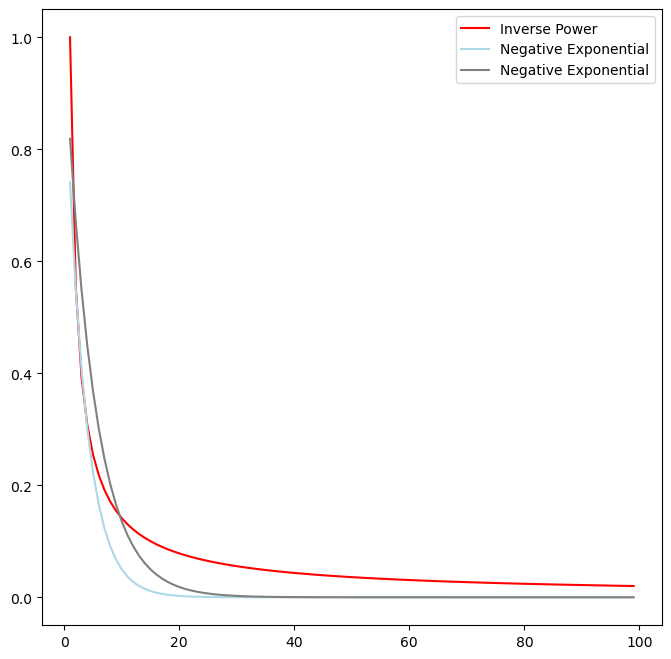

In [31]:
# Now let's consider some model tweaks.
# Starting with distance decay.
# Let's graph the distance decay parameters to get a feel for how they work.
xs = np.arange(1,100,1)
# inverse 0.85 power
y_inv_power = np.power(xs,-0.85)
# negative exponential, beta = 0.3
y_neg_exp_point3 = np.exp(-0.3*xs)
# negative exponential, beta = 0.2
y_neg_exp_point1 = np.exp(-0.2*xs)

# Now a plot.
f, ax = plt.subplots(figsize=(8,8))
ax.plot(xs,y_inv_power, label = "Inverse Power", color = "red")
ax.plot(xs,y_neg_exp_point3, label = 'Negative Exponential', color = "lightblue")
ax.plot(xs,y_neg_exp_point1, label = 'Negative Exponential', color = "gray")
ax.legend();

In [32]:
beta = 0.0002

In [33]:
dist_beta = np.exp(cleaned_data2['distance']*-beta)
Dj2_gamma = cleaned_data2["jobs"]**gamma
cleaned_data2["Ai1"] = Dj2_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(cleaned_data2.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i3"}, inplace=True)
#and write the A_i values back into the dataframe
cleaned_data2 = cleaned_data2.merge(A_i, left_on="station_origin", right_index=True, how="left")
cleaned_data2.head()

/tmp/ipykernel_22093/3518431497.py:5: FutureWarning: The provided callable <function sum at 0x7f705c5625c0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  A_i = pd.DataFrame(cleaned_data2.groupby(["station_origin"])["Ai1"].agg(np.sum))


,station_origin,station_destination,flows,population,jobs,distance,log_jobs,O_i,D_j,coef,alpha_i,prodsimest2,prodModelEst_exp,ScenarioA,Ai1,A_i2,prodsimest3,A_i3
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,11.271491,599,78549,Abbey Road,-2.920952,78.0,78.0,78549.0,984.578968,0.000097,84.0,0.000107
1,Abbey Road,Beckton,1,599,442,8510.121774,6.093570,599,442,Abbey Road,-2.920952,1.0,1.0,442.0,18.202100,0.000097,2.0,0.000107
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.501290,599,665,Abbey Road,-2.920952,4.0,4.0,665.0,63.891209,0.000097,4.0,0.000107
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,10.981438,599,58772,Abbey Road,-2.920952,100.0,100.0,29386.0,1453.897377,0.000097,63.0,0.000107
4,Abbey Road,Canning Town,37,599,15428,2228.923167,9.644004,599,15428,Abbey Road,-2.920952,56.0,56.0,15428.0,937.022978,0.000097,60.0,0.000107


In [34]:
cleaned_data2["prodsimest4"] = cleaned_data2["A_i3"]*cleaned_data2["O_i"]*Dj2_gamma*dist_beta
#round
cleaned_data2["prodsimest4"] = round(cleaned_data2["prodsimest4"])

flow_marix4 = cleaned_data2.pivot_table(values ="prodsimest4", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
flow_marix4

/tmp/ipykernel_22093/3893216574.py:5: FutureWarning: The provided callable <function sum at 0x7f705c5625c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  flow_marix4 = cleaned_data2.pivot_table(values ="prodsimest4", index="station_origin", columns = "station_destination",
/tmp/ipykernel_22093/3893216574.py:5: FutureWarning: The provided callable <function sum at 0x7f705c5625c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  flow_marix4 = cleaned_data2.pivot_table(values ="prodsimest4", index="station_origin", columns = "station_destination",
/tmp/ipykernel_22093/3893216574.py:5: FutureWarning: The provided callable <function sum at 0x7f705c5625c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used d

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,Archway,Arnos Grove,Arsenal,Baker Street,Balham,Bank and Monument,Barbican,Barking,Barkingside,Barons Court,Bayswater,Beckton,Beckton Park,Becontree,Belsize Park,Bermondsey,Bethnal Green,Blackfriars,Blackhorse Road,Blackwall,Bond Street,Borough,Boston Manor,Bounds Green,Bow Church,Bow Road,Brent Cross,Brentwood,Brixton,Brockley,Bromley-by-Bow,Brondesbury,Brondesbury Park,Bruce Grove,Buckhurst Hill,Burnt Oak,Bush Hill Park,Bushey,Caledonian Road,Caledonian Road & Barnsbury,Cambridge Heath,Camden Road,Camden Town,Canada Water,Canary Wharf,Canning Town,Cannon Street,Canonbury,Canons Park,Carpenders Park,Chadwell Heath,Chalfont & Latimer,Chalk Farm,Chancery Lane,Charing Cross,Chesham,Cheshunt,Chigwell,Chingford,Chiswick Park,Chorleywood,Clapham Common,Clapham High Street,Clapham Junction,Clapham North,Clapham South,Clapton,Cockfosters,Colindale,Colliers Wood,Covent Garden,Crossharbour,Crouch Hill,Croxley,Crystal Palace,Custom House,Cutty Sark,Cyprus,Dagenham East,Dagenham Heathway,Dalston Junction,Dalston Kingsland,Debden,Denmark Hill,Deptford Bridge,Devons Road,Dollis Hill,Ealing Broadway,Ealing Common,Earl's Court,East Acton,East Finchley,East Ham,East India,East Putney,Eastcote,Edgware,Edgware Road,Edmonton Green,Elephant & Castle,Elm Park,Elverson Road,Embankment,Emerson Park,Enfield Town,Epping,Euston,Euston Square,Fairlop,Farringdon,Finchley Central,Finchley Road,Finchley Road & Frognal,Finsbury Park,Forest Gate,Forest Hill,Fulham Broadway,Gallions Reach,Gants Hill,Gidea Park,Gloucester Road,Golders Green,Goldhawk Road,Goodge Street,Goodmayes,Gospel Oak,Grange Hill,Great Portland Street,Green Park,Greenford,Greenwich,Gunnersbury,Hackney Central,Hackney Downs,Hackney Wick,Haggerston,Hainault,Hammersmith,Hampstead,Hampstead Heath,Hanger Lane,Harlesden,Harold Wood,Harringay Green Lanes,Harrow & Wealdstone,Harrow-on-the-Hill,Hatch End,Hatton Cross,Headstone Lane,Heathrow Terminal 4,Heathrow Terminal 5,Heathrow Terminals 2 & 3,Hendon Central,Heron Quays,High Barnet,High Street Kensington,Highams Park,Highbury & Islington,Highgate,Hillingdon,Holborn,Holland Park,Holloway Road,Homerton,Honor Oak Park,Hornchurch,Hounslow Central,Hounslow East,Hounslow West,Hoxton,Hyde Park Corner,Ickenham,Ilford,Imperial Wharf,Island Gardens,Kennington,Kensal Green,Kensal Rise,Kensington,Kentish Town,Kentish Town West,Kenton,Kew Gardens,Kilburn,Kilburn High Road,Kilburn Park,King George V,King's Cross St. Pancras,Kingsbury,Knightsbridge,Ladbroke Grove,Lambeth North,Lancaster Gate,Langdon Park,Latimer Road,Leicester Square,Lewisham,Leyton,Leyton Midland Road,Leytonstone,Leytonstone High Road,Limehouse,Liverpool Street,London Bridge,London City Airport,London Fields,Loughton,Maida Vale,Manor House,Manor Park,Mansion House,Marble Arch,Maryland,Marylebone,Mile End,Mill Hill East,Moor Park,Moorgate,Morden,Mornington Crescent,Mudchute,Neasden,New Cross,New Cross Gate,Newbury Park,North Acton,North Ealing,North Greenwich,North Harrow,North Wembley,Northfields,Northolt,Northwick Park,Northwood,Northwood Hills,Norwood Junction,Notting Hill Gate,Oakwood,Old Street,Osterley,Oval,Oxford Circus,Paddington,Park Royal,Parsons Green,Peckham Rye,Penge West,Perivale,Piccadilly Circus,Pimlico,Pinner,Plaistow,Pontoon Dock,Poplar,Preston Road,Prince Regent,Pudding Mill Lane,Putney Bridge,Queen's Park,Queens Road Peckham,Queensbury,Queensway,Ravenscourt Park,Rayners Lane,Rectory Road,Redbridge,Regent's Park,Richmond,Rickmansworth,Roding Valley,Romford,Rotherhithe,Royal Albert,Royal Oak,Royal Victoria,Ruislip,Ruislip Gardens,Ruislip Manor,Russell Square,Seven Kings,Seven Sisters,Shadwell,Shenfield,Shepherd's Bush,Shepherd's Bush Market,Shoreditch High Street,Silver Street,Sloane Square,Snaresbrook,South Acton,South Ealing,South Hampstead,South Harrow,South Kensington,South Kenton,South Quay,South Ruislip,South Tottenham,South Wimbledon,South Woodford,Sou

In [35]:
beta = 0.0004

In [36]:
dist_beta = np.exp(cleaned_data2['distance']*-beta)
#calcualte the first stage of the Ai values
cleaned_data2["Ai1"] = Dj2_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(cleaned_data2.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i4"}, inplace=True)
#and write the A_i values back into the dataframe
cleaned_data2 = cleaned_data2.merge(A_i, left_on="station_origin", right_index=True, how="left")
cleaned_data2.head()

/tmp/ipykernel_22093/549701770.py:5: FutureWarning: The provided callable <function sum at 0x7f705c5625c0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  A_i = pd.DataFrame(cleaned_data2.groupby(["station_origin"])["Ai1"].agg(np.sum))


,station_origin,station_destination,flows,population,jobs,distance,log_jobs,O_i,D_j,coef,alpha_i,prodsimest2,prodModelEst_exp,ScenarioA,Ai1,A_i2,prodsimest3,A_i3,prodsimest4,A_i4
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,11.271491,599,78549,Abbey Road,-2.920952,78.0,78.0,78549.0,193.622248,0.000097,84.0,0.000107,63.0,0.000191
1,Abbey Road,Beckton,1,599,442,8510.121774,6.093570,599,442,Abbey Road,-2.920952,1.0,1.0,442.0,3.318499,0.000097,2.0,0.000107,1.0,0.000191
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.501290,599,665,Abbey Road,-2.920952,4.0,4.0,665.0,30.026850,0.000097,4.0,0.000107,4.0,0.000191
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,10.981438,599,58772,Abbey Road,-2.920952,100.0,100.0,29386.0,525.683979,0.000097,63.0,0.000107,93.0,0.000191
4,Abbey Road,Canning Town,37,599,15428,2228.923167,9.644004,599,15428,Abbey Road,-2.920952,56.0,56.0,15428.0,599.996110,0.000097,60.0,0.000107,60.0,0.000191


In [37]:
cleaned_data2["prodsimest5"] = cleaned_data2["A_i4"]*cleaned_data2["O_i"]*Dj2_gamma*dist_beta
#round
cleaned_data2["prodsimest5"] = round(cleaned_data2["prodsimest5"])

flow_marix5 = cleaned_data2.pivot_table(values ="prodsimest5", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
flow_marix5

/tmp/ipykernel_22093/2191708206.py:5: FutureWarning: The provided callable <function sum at 0x7f705c5625c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  flow_marix5 = cleaned_data2.pivot_table(values ="prodsimest5", index="station_origin", columns = "station_destination",
/tmp/ipykernel_22093/2191708206.py:5: FutureWarning: The provided callable <function sum at 0x7f705c5625c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  flow_marix5 = cleaned_data2.pivot_table(values ="prodsimest5", index="station_origin", columns = "station_destination",
/tmp/ipykernel_22093/2191708206.py:5: FutureWarning: The provided callable <function sum at 0x7f705c5625c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used d

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,Archway,Arnos Grove,Arsenal,Baker Street,Balham,Bank and Monument,Barbican,Barking,Barkingside,Barons Court,Bayswater,Beckton,Beckton Park,Becontree,Belsize Park,Bermondsey,Bethnal Green,Blackfriars,Blackhorse Road,Blackwall,Bond Street,Borough,Boston Manor,Bounds Green,Bow Church,Bow Road,Brent Cross,Brentwood,Brixton,Brockley,Bromley-by-Bow,Brondesbury,Brondesbury Park,Bruce Grove,Buckhurst Hill,Burnt Oak,Bush Hill Park,Bushey,Caledonian Road,Caledonian Road & Barnsbury,Cambridge Heath,Camden Road,Camden Town,Canada Water,Canary Wharf,Canning Town,Cannon Street,Canonbury,Canons Park,Carpenders Park,Chadwell Heath,Chalfont & Latimer,Chalk Farm,Chancery Lane,Charing Cross,Chesham,Cheshunt,Chigwell,Chingford,Chiswick Park,Chorleywood,Clapham Common,Clapham High Street,Clapham Junction,Clapham North,Clapham South,Clapton,Cockfosters,Colindale,Colliers Wood,Covent Garden,Crossharbour,Crouch Hill,Croxley,Crystal Palace,Custom House,Cutty Sark,Cyprus,Dagenham East,Dagenham Heathway,Dalston Junction,Dalston Kingsland,Debden,Denmark Hill,Deptford Bridge,Devons Road,Dollis Hill,Ealing Broadway,Ealing Common,Earl's Court,East Acton,East Finchley,East Ham,East India,East Putney,Eastcote,Edgware,Edgware Road,Edmonton Green,Elephant & Castle,Elm Park,Elverson Road,Embankment,Emerson Park,Enfield Town,Epping,Euston,Euston Square,Fairlop,Farringdon,Finchley Central,Finchley Road,Finchley Road & Frognal,Finsbury Park,Forest Gate,Forest Hill,Fulham Broadway,Gallions Reach,Gants Hill,Gidea Park,Gloucester Road,Golders Green,Goldhawk Road,Goodge Street,Goodmayes,Gospel Oak,Grange Hill,Great Portland Street,Green Park,Greenford,Greenwich,Gunnersbury,Hackney Central,Hackney Downs,Hackney Wick,Haggerston,Hainault,Hammersmith,Hampstead,Hampstead Heath,Hanger Lane,Harlesden,Harold Wood,Harringay Green Lanes,Harrow & Wealdstone,Harrow-on-the-Hill,Hatch End,Hatton Cross,Headstone Lane,Heathrow Terminal 4,Heathrow Terminal 5,Heathrow Terminals 2 & 3,Hendon Central,Heron Quays,High Barnet,High Street Kensington,Highams Park,Highbury & Islington,Highgate,Hillingdon,Holborn,Holland Park,Holloway Road,Homerton,Honor Oak Park,Hornchurch,Hounslow Central,Hounslow East,Hounslow West,Hoxton,Hyde Park Corner,Ickenham,Ilford,Imperial Wharf,Island Gardens,Kennington,Kensal Green,Kensal Rise,Kensington,Kentish Town,Kentish Town West,Kenton,Kew Gardens,Kilburn,Kilburn High Road,Kilburn Park,King George V,King's Cross St. Pancras,Kingsbury,Knightsbridge,Ladbroke Grove,Lambeth North,Lancaster Gate,Langdon Park,Latimer Road,Leicester Square,Lewisham,Leyton,Leyton Midland Road,Leytonstone,Leytonstone High Road,Limehouse,Liverpool Street,London Bridge,London City Airport,London Fields,Loughton,Maida Vale,Manor House,Manor Park,Mansion House,Marble Arch,Maryland,Marylebone,Mile End,Mill Hill East,Moor Park,Moorgate,Morden,Mornington Crescent,Mudchute,Neasden,New Cross,New Cross Gate,Newbury Park,North Acton,North Ealing,North Greenwich,North Harrow,North Wembley,Northfields,Northolt,Northwick Park,Northwood,Northwood Hills,Norwood Junction,Notting Hill Gate,Oakwood,Old Street,Osterley,Oval,Oxford Circus,Paddington,Park Royal,Parsons Green,Peckham Rye,Penge West,Perivale,Piccadilly Circus,Pimlico,Pinner,Plaistow,Pontoon Dock,Poplar,Preston Road,Prince Regent,Pudding Mill Lane,Putney Bridge,Queen's Park,Queens Road Peckham,Queensbury,Queensway,Ravenscourt Park,Rayners Lane,Rectory Road,Redbridge,Regent's Park,Richmond,Rickmansworth,Roding Valley,Romford,Rotherhithe,Royal Albert,Royal Oak,Royal Victoria,Ruislip,Ruislip Gardens,Ruislip Manor,Russell Square,Seven Kings,Seven Sisters,Shadwell,Shenfield,Shepherd's Bush,Shepherd's Bush Market,Shoreditch High Street,Silver Street,Sloane Square,Snaresbrook,South Acton,South Ealing,South Hampstead,South Harrow,South Kensington,South Kenton,South Quay,South Ruislip,South Tottenham,South Wimbledon,South Woodford,Sou

In [38]:
beta = 0.2

In [39]:
dist_beta = np.exp(cleaned_data2['distance']*-beta)
#calcualte the first stage of the Ai values
cleaned_data2["Ai1"] = Dj2_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(cleaned_data2.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i5"}, inplace=True)
#and write the A_i values back into the dataframe
cleaned_data2 = cleaned_data2.merge(A_i, left_on="station_origin", right_index=True, how="left")
cleaned_data2.head()

/tmp/ipykernel_22093/2477752653.py:5: FutureWarning: The provided callable <function sum at 0x7f705c5625c0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  A_i = pd.DataFrame(cleaned_data2.groupby(["station_origin"])["Ai1"].agg(np.sum))


,station_origin,station_destination,flows,population,jobs,distance,log_jobs,O_i,D_j,coef,alpha_i,prodsimest2,prodModelEst_exp,ScenarioA,Ai1,A_i2,prodsimest3,A_i3,prodsimest4,A_i4,prodsimest5,A_i5
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,11.271491,599,78549,Abbey Road,-2.920952,78.0,78.0,78549.0,0.000000e+00,0.000097,84.0,0.000107,63.0,0.000191,22.0,3.490825e+43
1,Abbey Road,Beckton,1,599,442,8510.121774,6.093570,599,442,Abbey Road,-2.920952,1.0,1.0,442.0,0.000000e+00,0.000097,2.0,0.000107,1.0,0.000191,0.0,3.490825e+43
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.501290,599,665,Abbey Road,-2.920952,4.0,4.0,665.0,0.000000e+00,0.000097,4.0,0.000107,4.0,0.000191,3.0,3.490825e+43
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,10.981438,599,58772,Abbey Road,-2.920952,100.0,100.0,29386.0,0.000000e+00,0.000097,63.0,0.000107,93.0,0.000191,60.0,3.490825e+43
4,Abbey Road,Canning Town,37,599,15428,2228.923167,9.644004,599,15428,Abbey Road,-2.920952,56.0,56.0,15428.0,3.660544e-191,0.000097,60.0,0.000107,60.0,0.000191,69.0,3.490825e+43


In [40]:
cleaned_data2["prodsimest6"] = cleaned_data2["A_i5"]*cleaned_data2["O_i"]*Dj2_gamma*dist_beta
#round
cleaned_data2["prodsimest6"] = round(cleaned_data2["prodsimest6"])

flow_marix6 = cleaned_data2.pivot_table(values ="prodsimest6", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
flow_marix6

/tmp/ipykernel_22093/3600181792.py:5: FutureWarning: The provided callable <function sum at 0x7f705c5625c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  flow_marix6 = cleaned_data2.pivot_table(values ="prodsimest6", index="station_origin", columns = "station_destination",
/tmp/ipykernel_22093/3600181792.py:5: FutureWarning: The provided callable <function sum at 0x7f705c5625c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'sum' instead.
  flow_marix6 = cleaned_data2.pivot_table(values ="prodsimest6", index="station_origin", columns = "station_destination",
/tmp/ipykernel_22093/3600181792.py:5: FutureWarning: The provided callable <function sum at 0x7f705c5625c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used d

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,Archway,Arnos Grove,Arsenal,Baker Street,Balham,Bank and Monument,Barbican,Barking,Barkingside,Barons Court,Bayswater,Beckton,Beckton Park,Becontree,Belsize Park,Bermondsey,Bethnal Green,Blackfriars,Blackhorse Road,Blackwall,Bond Street,Borough,Boston Manor,Bounds Green,Bow Church,Bow Road,Brent Cross,Brentwood,Brixton,Brockley,Bromley-by-Bow,Brondesbury,Brondesbury Park,Bruce Grove,Buckhurst Hill,Burnt Oak,Bush Hill Park,Bushey,Caledonian Road,Caledonian Road & Barnsbury,Cambridge Heath,Camden Road,Camden Town,Canada Water,Canary Wharf,Canning Town,Cannon Street,Canonbury,Canons Park,Carpenders Park,Chadwell Heath,Chalfont & Latimer,Chalk Farm,Chancery Lane,Charing Cross,Chesham,Cheshunt,Chigwell,Chingford,Chiswick Park,Chorleywood,Clapham Common,Clapham High Street,Clapham Junction,Clapham North,Clapham South,Clapton,Cockfosters,Colindale,Colliers Wood,Covent Garden,Crossharbour,Crouch Hill,Croxley,Crystal Palace,Custom House,Cutty Sark,Cyprus,Dagenham East,Dagenham Heathway,Dalston Junction,Dalston Kingsland,Debden,Denmark Hill,Deptford Bridge,Devons Road,Dollis Hill,Ealing Broadway,Ealing Common,Earl's Court,East Acton,East Finchley,East Ham,East India,East Putney,Eastcote,Edgware,Edgware Road,Edmonton Green,Elephant & Castle,Elm Park,Elverson Road,Embankment,Emerson Park,Enfield Town,Epping,Euston,Euston Square,Fairlop,Farringdon,Finchley Central,Finchley Road,Finchley Road & Frognal,Finsbury Park,Forest Gate,Forest Hill,Fulham Broadway,Gallions Reach,Gants Hill,Gidea Park,Gloucester Road,Golders Green,Goldhawk Road,Goodge Street,Goodmayes,Gospel Oak,Grange Hill,Great Portland Street,Green Park,Greenford,Greenwich,Gunnersbury,Hackney Central,Hackney Downs,Hackney Wick,Haggerston,Hainault,Hammersmith,Hampstead,Hampstead Heath,Hanger Lane,Harlesden,Harold Wood,Harringay Green Lanes,Harrow & Wealdstone,Harrow-on-the-Hill,Hatch End,Hatton Cross,Headstone Lane,Heathrow Terminal 4,Heathrow Terminal 5,Heathrow Terminals 2 & 3,Hendon Central,Heron Quays,High Barnet,High Street Kensington,Highams Park,Highbury & Islington,Highgate,Hillingdon,Holborn,Holland Park,Holloway Road,Homerton,Honor Oak Park,Hornchurch,Hounslow Central,Hounslow East,Hounslow West,Hoxton,Hyde Park Corner,Ickenham,Ilford,Imperial Wharf,Island Gardens,Kennington,Kensal Green,Kensal Rise,Kensington,Kentish Town,Kentish Town West,Kenton,Kew Gardens,Kilburn,Kilburn High Road,Kilburn Park,King George V,King's Cross St. Pancras,Kingsbury,Knightsbridge,Ladbroke Grove,Lambeth North,Lancaster Gate,Langdon Park,Latimer Road,Leicester Square,Lewisham,Leyton,Leyton Midland Road,Leytonstone,Leytonstone High Road,Limehouse,Liverpool Street,London Bridge,London City Airport,London Fields,Loughton,Maida Vale,Manor House,Manor Park,Mansion House,Marble Arch,Maryland,Marylebone,Mile End,Mill Hill East,Moor Park,Moorgate,Morden,Mornington Crescent,Mudchute,Neasden,New Cross,New Cross Gate,Newbury Park,North Acton,North Ealing,North Greenwich,North Harrow,North Wembley,Northfields,Northolt,Northwick Park,Northwood,Northwood Hills,Norwood Junction,Notting Hill Gate,Oakwood,Old Street,Osterley,Oval,Oxford Circus,Paddington,Park Royal,Parsons Green,Peckham Rye,Penge West,Perivale,Piccadilly Circus,Pimlico,Pinner,Plaistow,Pontoon Dock,Poplar,Preston Road,Prince Regent,Pudding Mill Lane,Putney Bridge,Queen's Park,Queens Road Peckham,Queensbury,Queensway,Ravenscourt Park,Rayners Lane,Rectory Road,Redbridge,Regent's Park,Richmond,Rickmansworth,Roding Valley,Romford,Rotherhithe,Royal Albert,Royal Oak,Royal Victoria,Ruislip,Ruislip Gardens,Ruislip Manor,Russell Square,Seven Kings,Seven Sisters,Shadwell,Shenfield,Shepherd's Bush,Shepherd's Bush Market,Shoreditch High Street,Silver Street,Sloane Square,Snaresbrook,South Acton,South Ealing,South Hampstead,South Harrow,South Kensington,South Kenton,South Quay,South Ruislip,South Tottenham,South Wimbledon,South Woodford,Sou